## **Uso do Algoritmo de Kruskal na otimização de roteiro Turístico**

---




**Requisito #01**

Dado um dos problemas anteriores, escolha
alguns pontos de interesse (PoI - points of
interest) e calcule a MST para esses pontos.
Use o notebook kruskal_natal.ipynb como
referência.

Dessa forma, este projeto utiliza o **algoritmo de Kruskal** para calcular a  MST que conecta os principais pontos turísticos da cidade de Natal-RN, criando um roteiro eficiente que minimiza as distâncias percorridas.



#### **Algoritmo de Kruskal**

- O algoritmo de Kruskal é um método amplamente utilizado para determinar a Árvore Geradora Mínima (Minimum Spanning Tree - MST) em um grafo ponderado e conectado. Ele busca conectar todos os vértices, ou pontos, de forma que a soma das distâncias seja a menor possível, sem criar ciclos

In [ ]:
!pip install osmnx

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt


In [ ]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

In [ ]:
# ============================================
# 1. Obter o grafo da cidade de Natal
# ============================================
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

In [ ]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
tags = {'tourism': 'attraction'}
pois = ox.features.features_from_place(place, tags=tags)

# Extrair pontos representativos (centroides se for polígono)
tourism_points = []
for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        tourism_points.append((row.geometry.y, row.geometry.x))
    else:
       tourism_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not tourism_points:
    print("Ponto turistico encontrado. Tentando escolas...")
    tags = {'amenity': 'school'}
    pois = ox.features.features_from_place(place, tags=tags)
    for idx, row in pois.iterrows():
        if row.geometry.geom_type == 'Point':
          tourism_points.append((row.geometry.y, row.geometry.x))
        else:
            tourism_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
    if not tourism_points:
        raise ValueError("Nenhum POI encontrado para as categorias tentadas.")

In [ ]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in tourism_points]
longitudes = [hp[1] for hp in tourism_points]
tourism_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
tourism_nodes = list(set(tourism_nodes))

if len(tourism_nodes) < 2:
    raise ValueError("POIs insuficientes para criar um MST (menos de 2 pontos).")

# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(tourism_nodes)):
    for j in range(i+1, len(tourism_nodes)):
        route = nx.shortest_path(G_undirected, tourism_nodes[i], tourism_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(tourism_nodes[i], tourism_nodes[j], weight=route_length)

# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")
###
# Criar a lista de rotas a partir das arestas do MST
mst_routes = [[u, v] for u, v, d in mst_edges]

Comprimento total do MST entre os POIs selecionados: 28823.45123912635 metros


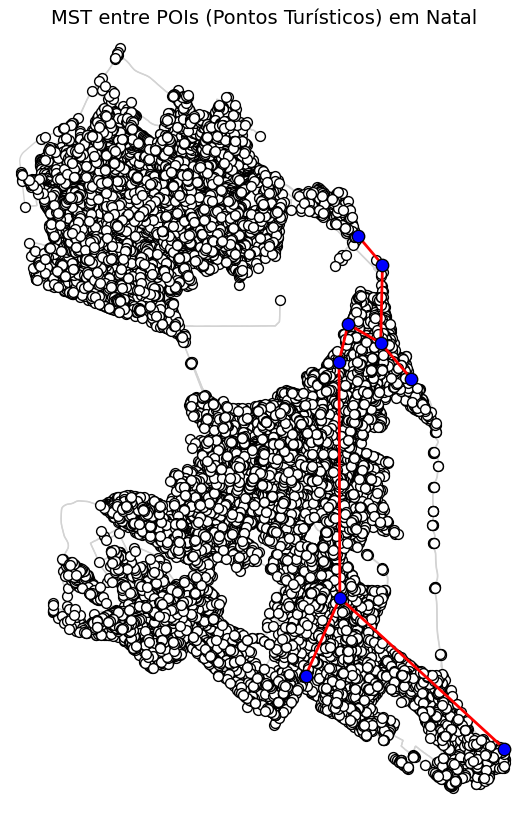

In [ ]:
# Supondo que você já tenha as variáveis:
# G_undirected: grafo MultiGraph não-direcionado
# hospital_nodes: lista de nós próximos aos hospitais
# mst_routes: lista de rotas do MST (cada rota é uma lista de nós)
# latitudes, longitudes: listas com lat/long dos pontos turisticos
# Caso não tenha sido definido, você pode calcular um bbox se quiser
# bbox_padding = 0.02
# north = max(latitudes) + bbox_padding
# south = min(latitudes) - bbox_padding
# east = max(longitudes) + bbox_padding
# west = min(longitudes) - bbox_padding

# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected,
    # Caso queira o bbox, descomente a linha abaixo:
    # bbox=(north, south, east, west),
    show=False,
    close=False,
    node_color='white',
    node_edgecolor='black',
    node_size=50,
    edge_color='lightgray',
    edge_linewidth=1,
    bgcolor='white',    # fundo branco
    figsize=(10,10)
)

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (pontos turisticos) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in tourism_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in tourism_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black')

plt.title("MST entre POIs (Pontos Turísticos) em Natal", fontsize=14)
plt.show()


- O comprimento total da MST, equivalente a 28.823,45 metros, representa a menor distância necessária para conectar todos os pontos turísticos selecionados. Esse valor reflete um roteiro otimizado que reduz deslocamentos, tornando-o ideal para turistas que desejam explorar diversos locais de forma prática e eficiente. Além disso, a rota oferece uma solução estratégica para planejamento de transporte turístico, reduzindo custos operacionais e tempo de viagem, além de possibilitar a criação de itinerários guiados personalizados.
